In [1]:
import torch.nn as nn
from torchvision import models
import numpy as np
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
import cv2
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from ex import *

In [2]:
test_size = 0.3
val_size = 0.3

In [3]:
train = pd.read_csv("./../../../../Data/Adult/adult.csv")

In [4]:
train = train.replace({"salary" : {' <=50K' : 0, ' >50K' : 1}})

In [5]:
train_y = train.pop("salary").values

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
cat_col = train.select_dtypes("object").columns.tolist()
for col in cat_col :
    train[col] = LabelEncoder().fit_transform(train[col])

In [8]:
train_x = train.values

In [9]:
test_size = 0.3
val_size = 0.3

In [10]:
x_train, x_test, y_train, y_test \
        = train_test_split(train_x,train_y, test_size=test_size, random_state=1)
x_train, x_val, y_train, y_val \
        = train_test_split(x_train, y_train, test_size=val_size, random_state=1)

In [11]:
x_train.shape , x_val.shape , x_test.shape

((15954, 14), (6838, 14), (9769, 14))

In [12]:
device="cpu"
batch_size = 200
kwargs = {} if device=='cpu' else {'num_workers': 2, 'pin_memory': True}
loader_kwargs = {'batch_size':batch_size, **kwargs}

In [13]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

In [27]:
# Build Dataset
train_data = CustomTensorDataset(data=(x_train, y_train), transform=transform,
                                 dataset="adult",n_columns=2)
val_data   = CustomTensorDataset(data=(x_val, y_val), transform=transform,
                                 dataset="adult",n_columns=2)
test_data  = CustomTensorDataset(data=(x_test, y_test), transform=transform,
                                dataset="adult",n_columns=2)
train_loader = DataLoader(train_data, shuffle=False, **loader_kwargs)
val_loader   = DataLoader(val_data, shuffle=True, **loader_kwargs)
test_loader  = DataLoader(test_data, shuffle=False, **loader_kwargs)

In [28]:
x , y = next(iter(train_loader))

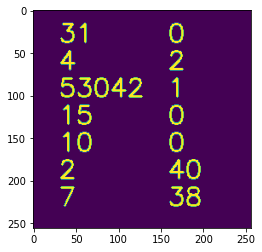

In [29]:
plt.imshow(x[0,1,:])

In [30]:
x_train[0,:]

array([   31,     4, 53042,    15,    10,     2,     7,     0,     2,
           1,     0,     0,    40,    38])

In [31]:
model = load_model("resnet18",2)    

In [32]:
opt='Adagrad'

In [33]:
optimizer = opt_selection(model, opt)

In [34]:
criterion = nn.CrossEntropyLoss()

In [35]:
best_train, best_val = 0.0, 0.0
epochs = 100

In [ ]:
import copy
for epoch in range(1, epochs+1):
    # Train and Validate
    train_stats = train_step(model, criterion, optimizer, train_loader,"classification")
    valid_stats = valid_step(model, criterion, val_loader,"classification")
    print("train", train_stats)
    print("valid", valid_stats)
    # Keep best model
    if valid_stats['metric'] > best_val or (valid_stats['metric']==best_val and train_stats['accuracy']>=best_train):
        best_train  = train_stats['metric']
        best_val    = valid_stats['metric']
        best_model_weights = copy.deepcopy(model.state_dict())

# Load best model and evaluate on test set
model.load_state_dict(best_model_weights)
test_stats = valid_step(model, criterion, test_loader)
print('\nBests Model Accuracies: Train: {:4.2f} | Val: {:4.2f} | Test: {:4.2f}'.format(best_train, best_val, test_stats['accuracy']))

train {'loss': 0.34677042737603186, 'metric': 0.8394133132756676}
valid {'loss': 169.17142857142858, 'metric': 0.8658964609534952}
